# **Librerías y carga de datos**
En esta sección se importan todas las libreríaas que son necesarias para la limpieza y transformación de los datos.

In [ ]:
# Instalaciones
# ==============================================================================
!pip install kmodes

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Gestión de librerías
# ==============================================================================
from importlib import reload


# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

# Modelos
# ==============================================================================
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from branca.element import Template, MacroElement

# Conexion Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


encoder = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/label_encoders.pkl')

Mounted at /content/drive


# **Modelo con no normalizados - Variables:** conducta, modalidad, arma_medio


In [ ]:
# Importar datos
# ==============================================================================
df1 = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
var = ['conducta', 'modalidad', 'arma_medio']
df1 = df1.sample(n=30000, random_state=42)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 42909 to 64913
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitud         30000 non-null  float64
 1   longitud        30000 non-null  float64
 2   sexo            30000 non-null  int64  
 3   edad            30000 non-null  int64  
 4   estado_civil    30000 non-null  int64  
 5   conducta        30000 non-null  int64  
 6   modalidad       30000 non-null  int64  
 7   arma_medio      30000 non-null  int64  
 8   codigo_comuna   30000 non-null  int64  
 9   lugar           30000 non-null  int64  
 10  categoria_bien  30000 non-null  int64  
 11  día             30000 non-null  int64  
 12  mes             30000 non-null  int64  
 13  zona            30000 non-null  int64  
 14  rango_hora      30000 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 3.7 MB


2
3
4
5
6
7
8
9
10


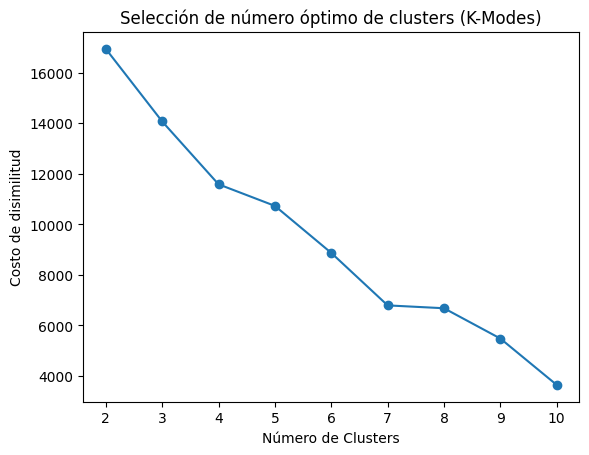

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

costs = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(df1[var])
    print(k)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Costo de disimilitud')
plt.title('Selección de número óptimo de clusters (K-Modes)')
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# Kluster
k_optimo = 5
kmodes_final = KModes(n_clusters=k_optimo, init='Huang', n_init=10, verbose=1, random_state= 42)
df1['cluster'] = kmodes_final.fit_predict(df1[var])

# Análisis de los clusters
cluster_summary = df1.groupby('cluster').agg(lambda x: x.mode().iloc[0])

print("Resumen por cluster:")
print(cluster_summary)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6510, cost: 10211.0
Run 1, iteration: 2/100, moves: 685, cost: 10211.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 10556.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6461, cost: 11264.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1038, cost: 10278.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3418, cost: 21360.0
Run 5, iteration: 2/100, moves: 0, cost: 21360.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 12769.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 37

In [ ]:
# visualizacion mapa
# ==============================================================================


df_dots = df1[["latitud", "longitud", "cluster"]]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa





Output hidden; open in https://colab.research.google.com to view.

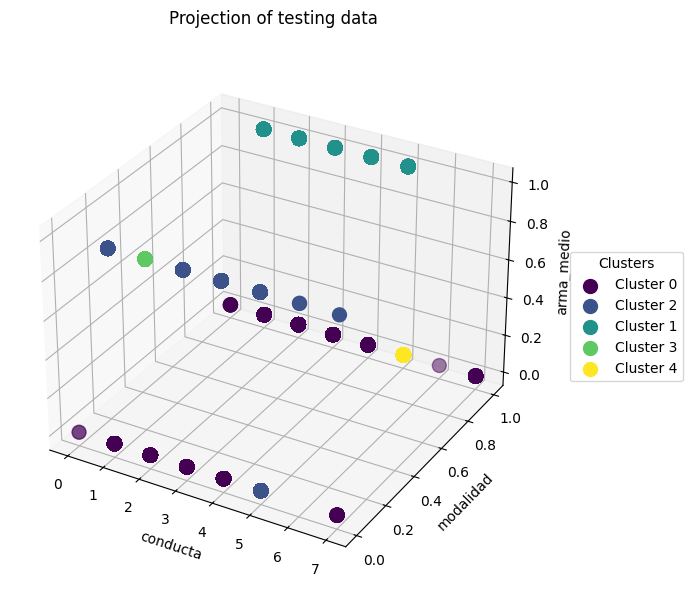

In [ ]:
# visualizacion de variables clusterizadas
# ==============================================================================

fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Obtener los clusters únicos
clusters_unicos = df1['cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters_unicos)))

# Graficar cada cluster por separado con su respectiva etiqueta
for i, cluster in enumerate(clusters_unicos):
    subset = df1[df1['cluster'] == cluster]
    kernel_pca_proj_ax.scatter(
        subset[var[0]],
        subset[var[1]],
        subset[var[2]],
        color=colors[i],
        label=f'Cluster {cluster}',
        s=100
    )

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel(var[0])
kernel_pca_proj_ax.set_ylabel(var[1])
kernel_pca_proj_ax.set_zlabel(var[2])
kernel_pca_proj_ax.set_title("Projection of testing data\n")
kernel_pca_proj_ax.legend(title="Clusters")

kernel_pca_proj_ax.legend(
    title="Clusters",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

plt.tight_layout()
plt.show()


In [ ]:
# Volver a valores originales para analisis
# ==============================================================================

cluster_summary = df1.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df1.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()


,cluster,conducta,modalidad,arma_medio,Cantidad
0,0,Hurto a persona,violentos,Con_Arma,13080
1,1,Hurto a persona,violentos,Sin_arma,2635
2,2,Hurto de moto,no_violentos,Sin_arma,6069
3,3,Hurto a persona,no_violentos,Sin_arma,6845
4,4,Hurto de moto,violentos,Con_Arma,1371


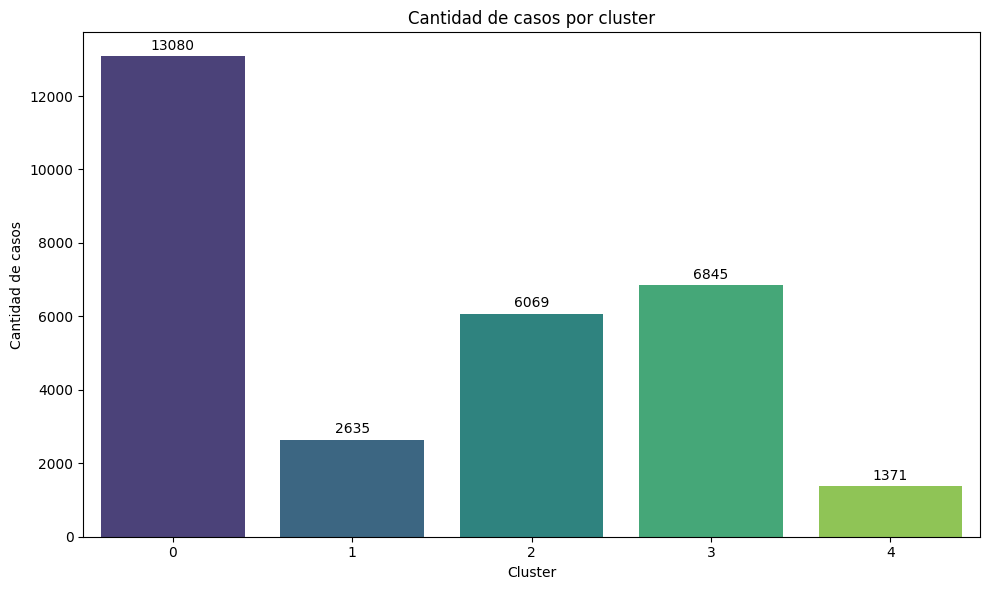

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

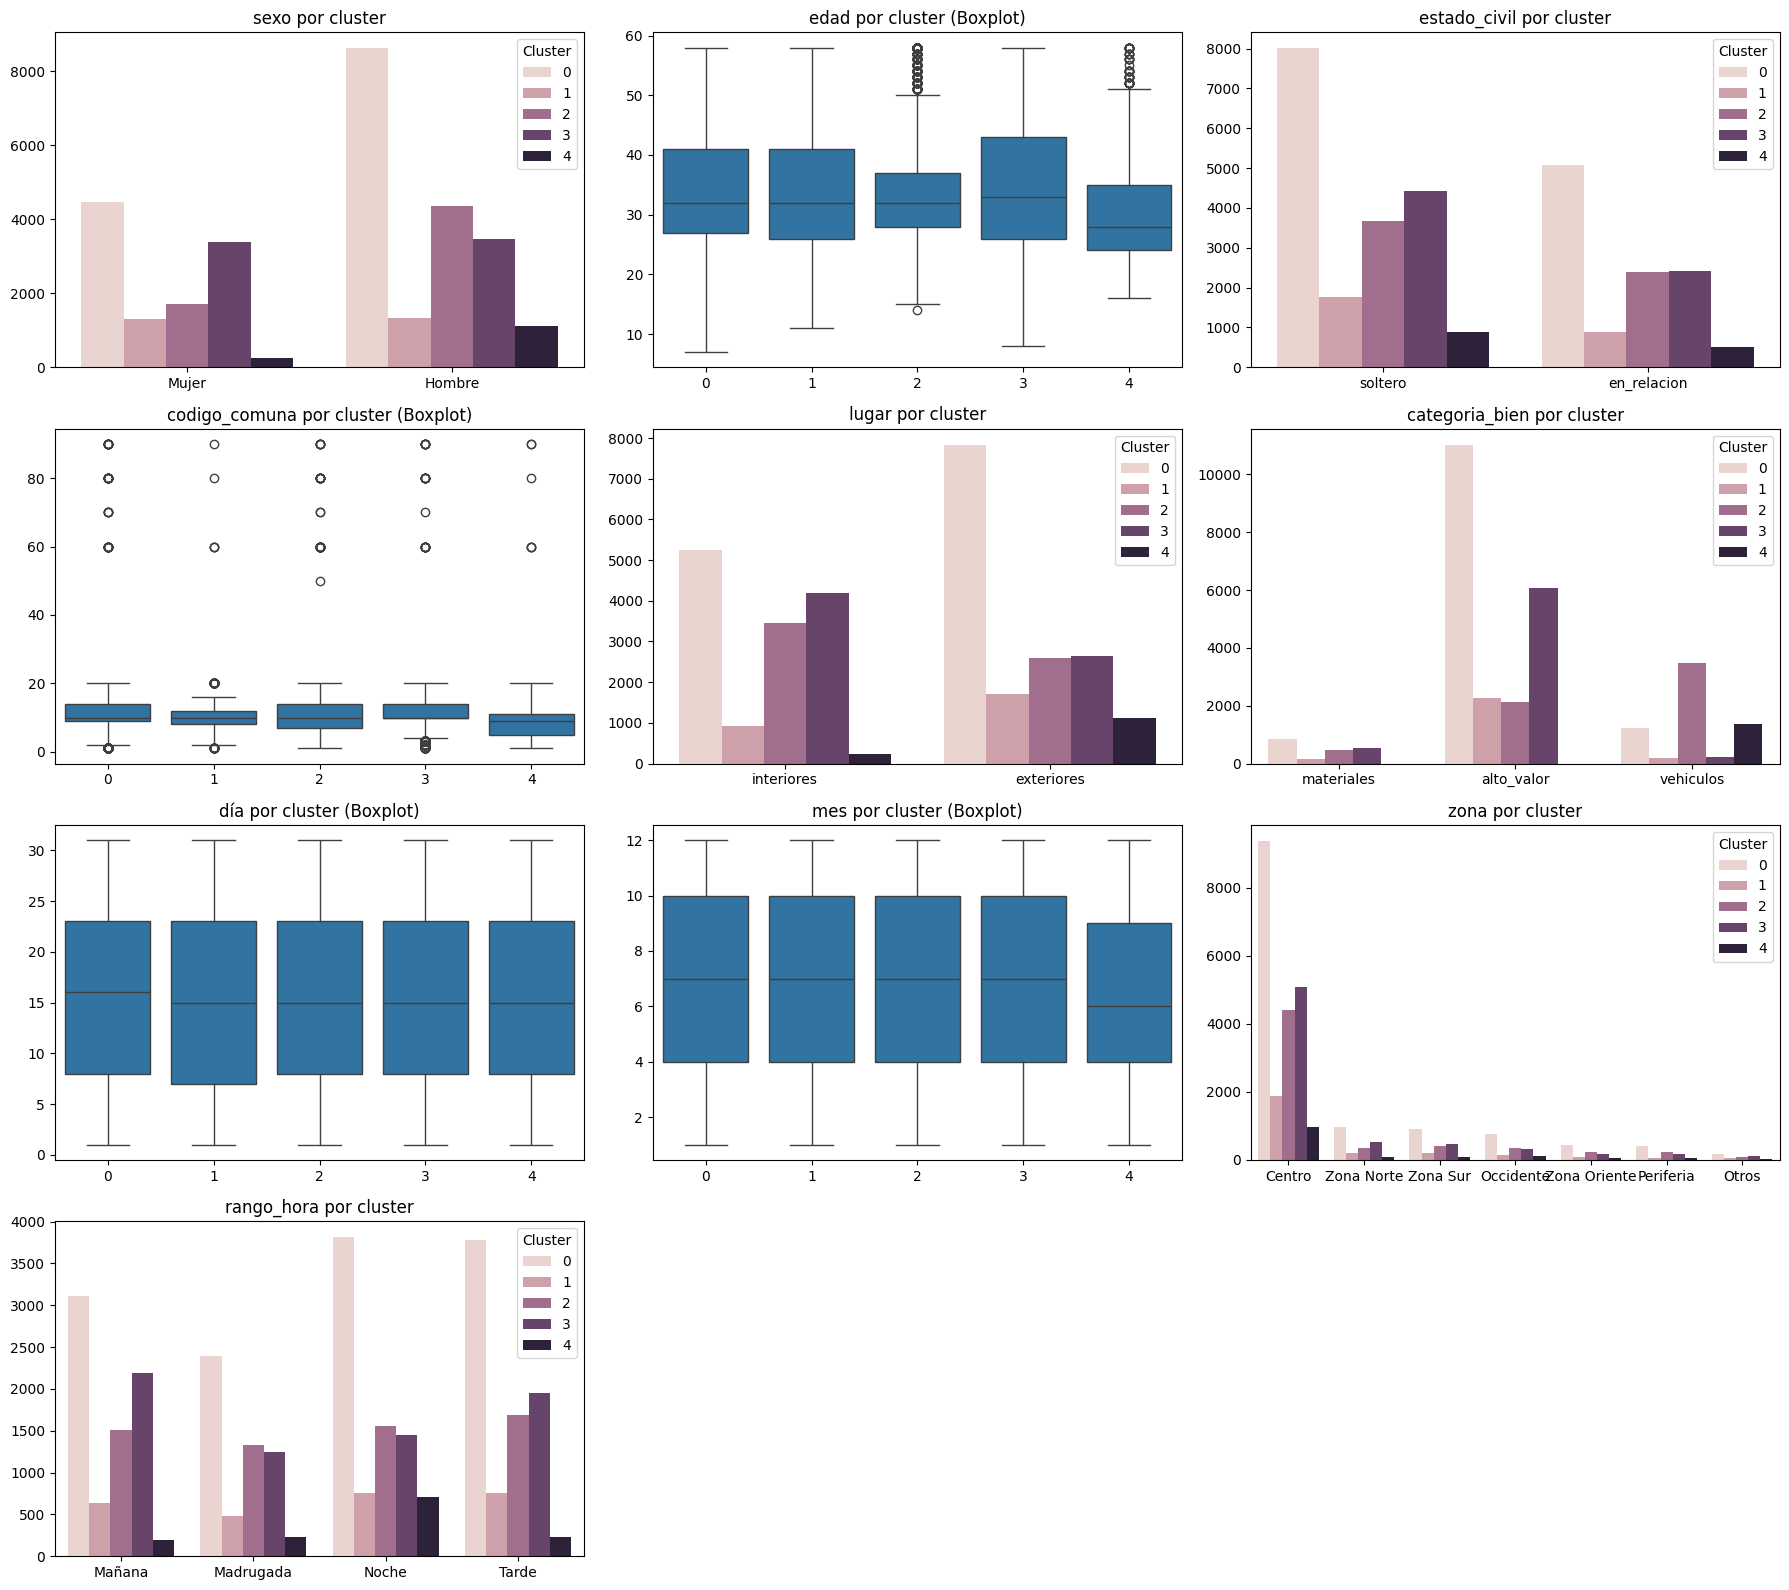

In [ ]:
for col in df1.columns:
    if col in encoder:
        df1[col] = df1[col].round().astype(int)
        df1[col] = encoder[col].inverse_transform(df1[col])

# Variables a analizar (excluimos latitud y longitud)
vars_to_plot = [col for col in df1.columns if col not in var + ['latitud', 'longitud', 'cluster', 'dia']]

# Graficar
n = len(vars_to_plot)
cols = 3
rows = (n // cols) + int(n % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    if df1[var].nunique() <= 10:

        sns.countplot(data=df1, x=var, hue='cluster', ax=ax)
        ax.set_title(f'{var} por cluster')
        ax.legend(title='Cluster')
    else:

        sns.boxplot(data=df1, x='cluster', y=var, ax=ax)
        ax.set_title(f'{var} por cluster (Boxplot)')

    ax.set_xlabel('')
    ax.set_ylabel('')


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **Modelo con no normalizados - Variables:** lugar, categoria_bien, rango_hora

In [ ]:
# Importar datos
# ==============================================================================
df2 = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
var = ['lugar', 'categoria_bien', 'rango_hora']
df2 = df2.sample(n=30000, random_state=42)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 42909 to 64913
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitud         30000 non-null  float64
 1   longitud        30000 non-null  float64
 2   sexo            30000 non-null  int64  
 3   edad            30000 non-null  int64  
 4   estado_civil    30000 non-null  int64  
 5   conducta        30000 non-null  int64  
 6   modalidad       30000 non-null  int64  
 7   arma_medio      30000 non-null  int64  
 8   codigo_comuna   30000 non-null  int64  
 9   lugar           30000 non-null  int64  
 10  categoria_bien  30000 non-null  int64  
 11  día             30000 non-null  int64  
 12  mes             30000 non-null  int64  
 13  zona            30000 non-null  int64  
 14  rango_hora      30000 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 3.7 MB


2
3
4
5
6
7
8
9
10


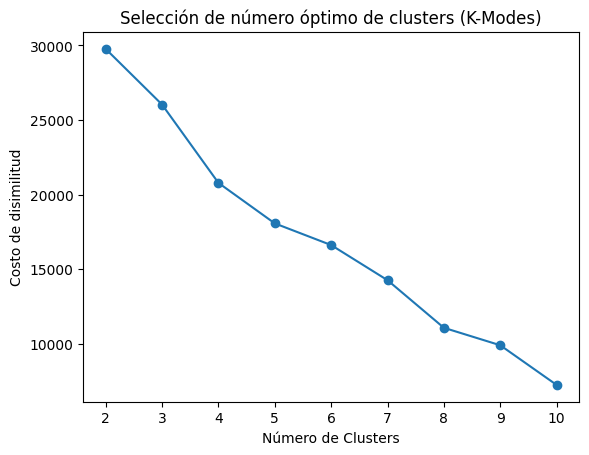

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

costs = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(df2[var])
    print(k)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Costo de disimilitud')
plt.title('Selección de número óptimo de clusters (K-Modes)')
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# Kluster
k_optimo = 5
kmodes_final = KModes(n_clusters=k_optimo, init='Huang', n_init=10, verbose=1, random_state= 42)
df2['cluster'] = kmodes_final.fit_predict(df2[var])

# Análisis de los clusters
cluster_summary = df2.groupby('cluster').agg(lambda x: x.mode().iloc[0])

print("Resumen por cluster:")
print(cluster_summary)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3921, cost: 19602.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 18327.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 6576, cost: 17380.0
Run 3, iteration: 2/100, moves: 1470, cost: 17380.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10014, cost: 21483.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 6444, cost: 22087.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 6288, cost: 22805.0
Run 6, iteration: 2/100, moves: 203, cost: 22805.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, mo

In [ ]:
# visualizacion mapa
# ==============================================================================


df_dots = df2[["latitud", "longitud", "cluster"]]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa





Output hidden; open in https://colab.research.google.com to view.

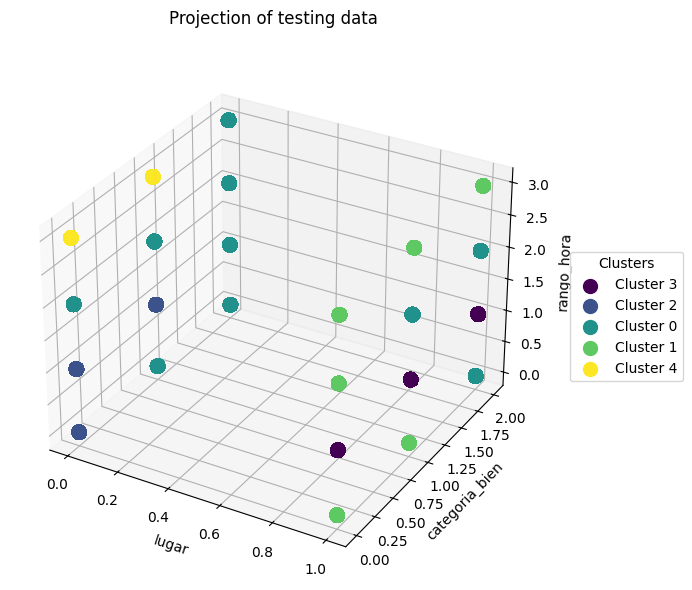

In [ ]:
# visualizacion de variables clusterizadas
# ==============================================================================

fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Obtener los clusters únicos
clusters_unicos = df2['cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters_unicos)))

# Graficar cada cluster por separado con su respectiva etiqueta
for i, cluster in enumerate(clusters_unicos):
    subset = df2[df2['cluster'] == cluster]
    kernel_pca_proj_ax.scatter(
        subset[var[0]],
        subset[var[1]],
        subset[var[2]],
        color=colors[i],
        label=f'Cluster {cluster}',
        s=100
    )

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel(var[0])
kernel_pca_proj_ax.set_ylabel(var[1])
kernel_pca_proj_ax.set_zlabel(var[2])
kernel_pca_proj_ax.set_title("Projection of testing data\n")
kernel_pca_proj_ax.legend(title="Clusters")

kernel_pca_proj_ax.legend(
    title="Clusters",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

plt.tight_layout()
plt.show()


In [ ]:
# Volver a valores originales para analisis
# ==============================================================================

cluster_summary = df2.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df2.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()


,cluster,lugar,categoria_bien,rango_hora,Cantidad
0,0,exteriores,vehiculos,Noche,6426
1,1,exteriores,alto_valor,Noche,9856
2,2,interiores,alto_valor,Tarde,6269
3,3,interiores,alto_valor,Mañana,3905
4,4,exteriores,alto_valor,Tarde,3544


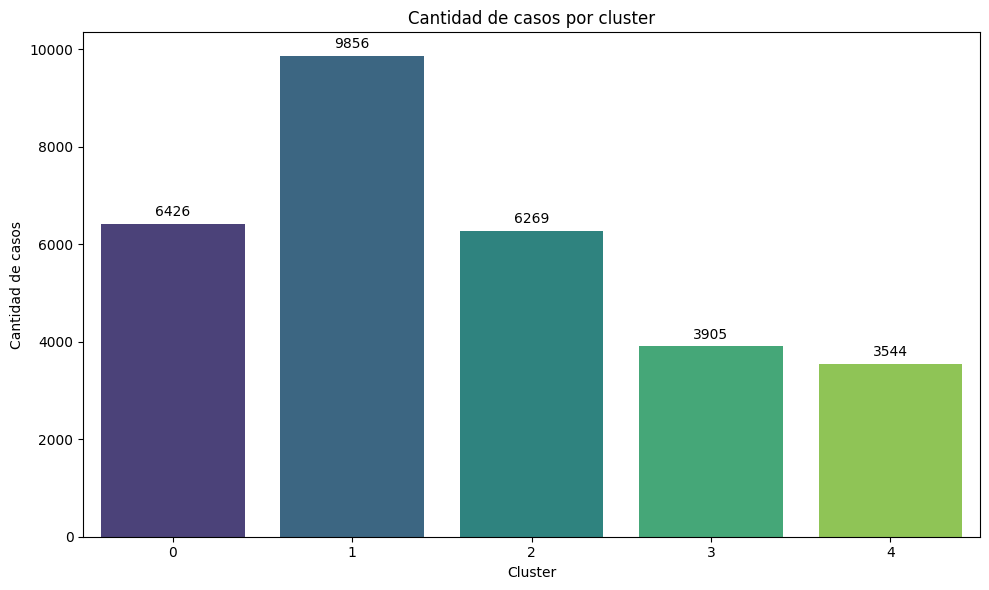

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

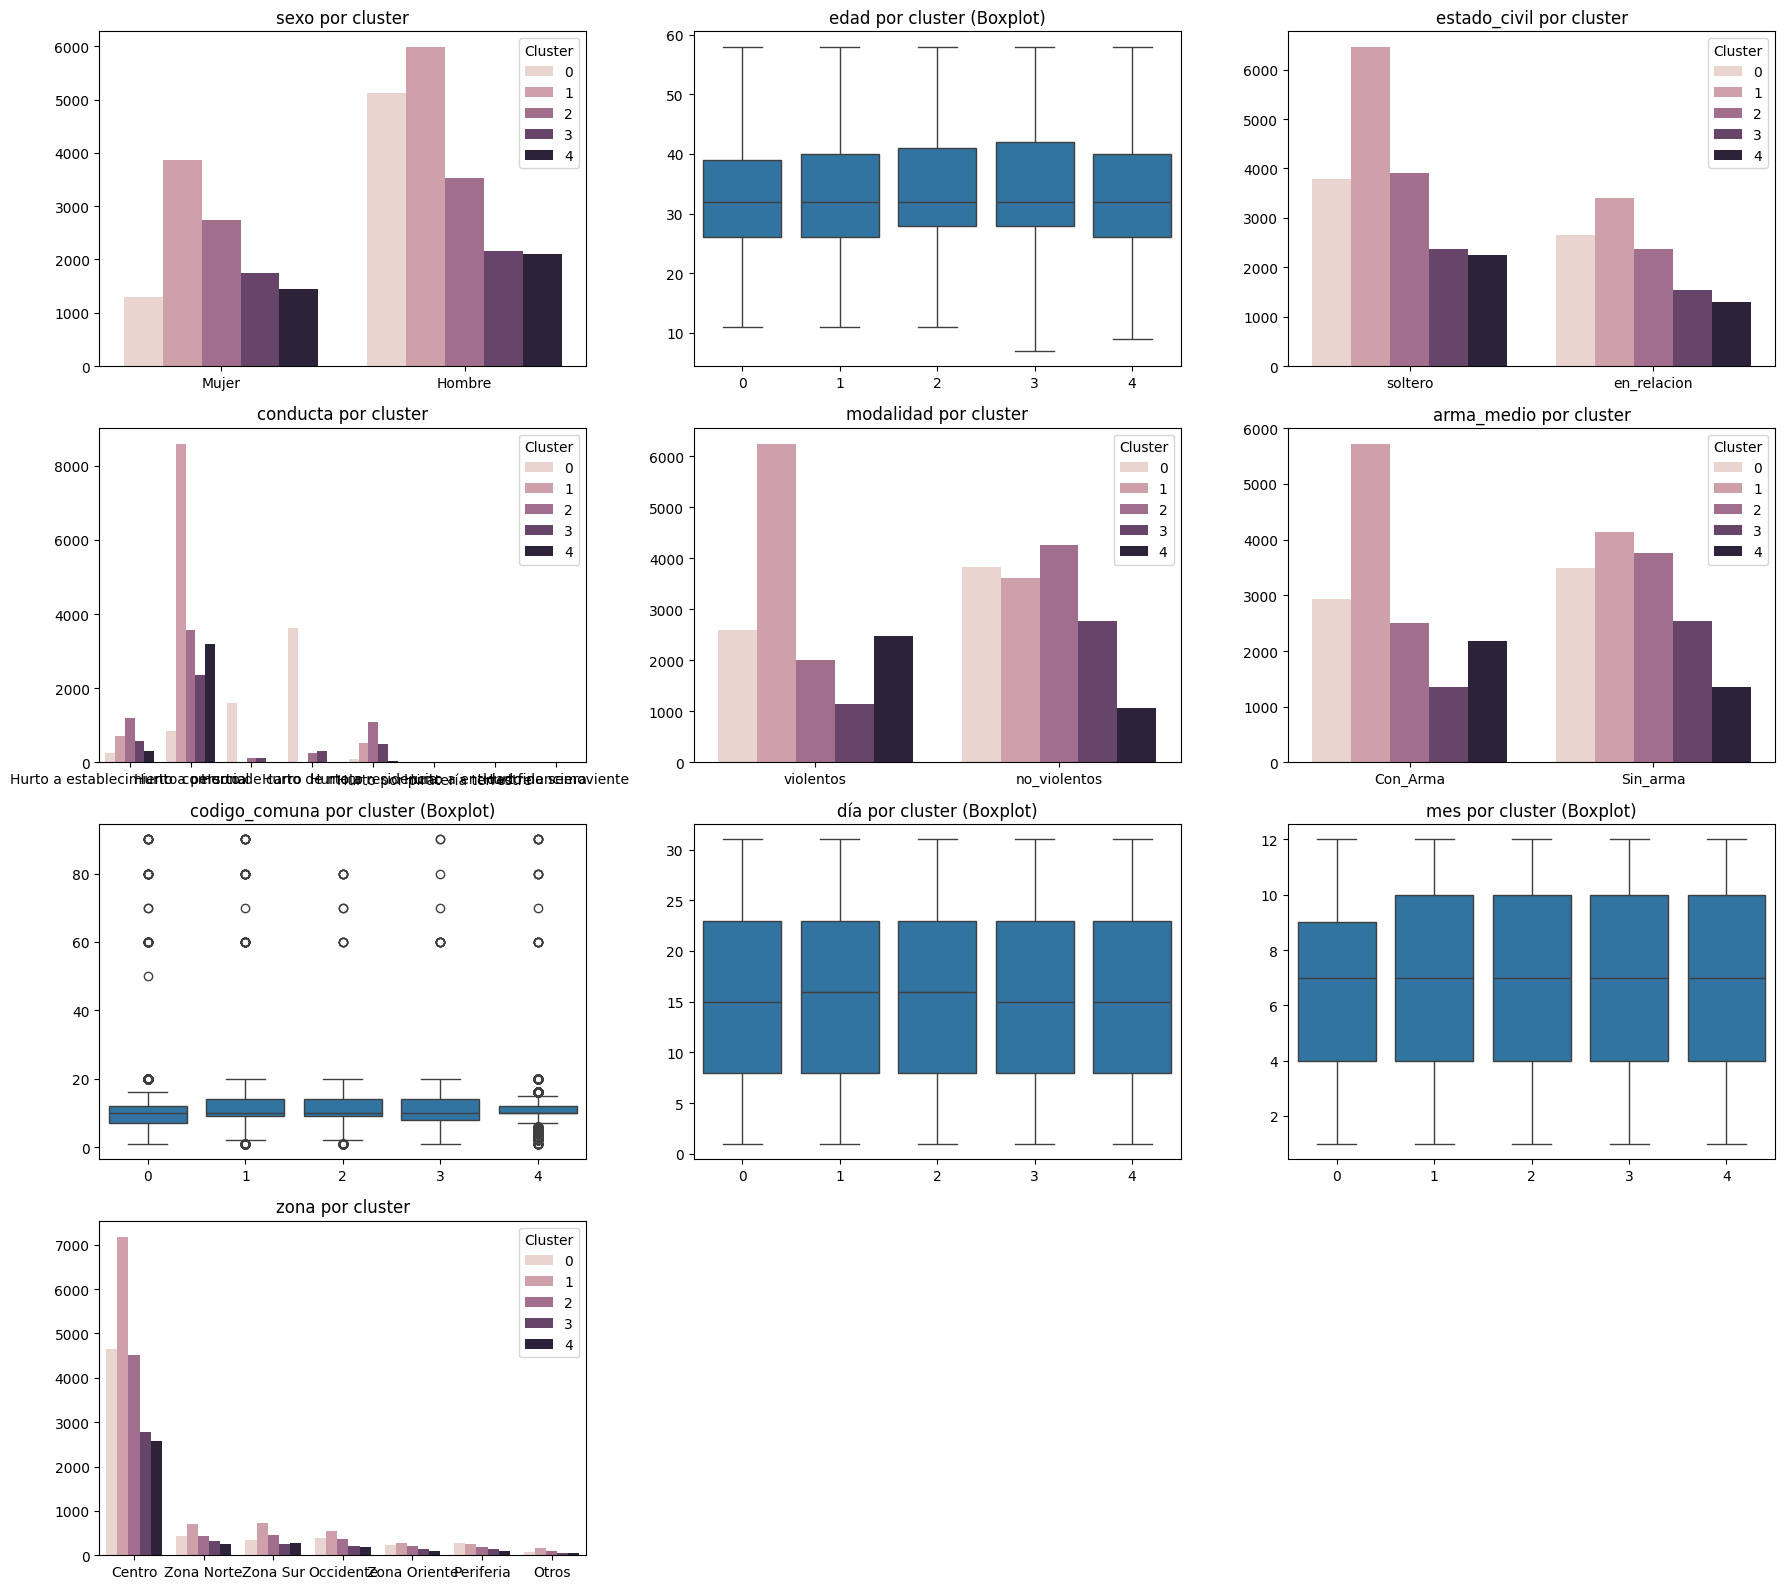

In [ ]:
for col in df2.columns:
    if col in encoder:
        df2[col] = df2[col].round().astype(int)
        df2[col] = encoder[col].inverse_transform(df2[col])


# Variables a analizar (excluimos latitud y longitud)
vars_to_plot = [col for col in df2.columns if col not in var + ['latitud', 'longitud', 'cluster', 'dia']]

# Graficar
n = len(vars_to_plot)
cols = 3
rows = (n // cols) + int(n % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    if df2[var].nunique() <= 10:

        sns.countplot(data=df2, x=var, hue='cluster', ax=ax)
        ax.set_title(f'{var} por cluster')
        ax.legend(title='Cluster')
    else:

        sns.boxplot(data=df2, x='cluster', y=var, ax=ax)
        ax.set_title(f'{var} por cluster (Boxplot)')

    ax.set_xlabel('')
    ax.set_ylabel('')


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **Modelo con no normalizados - Variables:** sexo, estado_civil, zona

In [ ]:
# Importar datos
# ==============================================================================
df3 = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
var = ['sexo', 'estado_civil', 'zona']
df3 = df3.sample(n=30000, random_state=42)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 42909 to 64913
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitud         30000 non-null  float64
 1   longitud        30000 non-null  float64
 2   sexo            30000 non-null  int64  
 3   edad            30000 non-null  int64  
 4   estado_civil    30000 non-null  int64  
 5   conducta        30000 non-null  int64  
 6   modalidad       30000 non-null  int64  
 7   arma_medio      30000 non-null  int64  
 8   codigo_comuna   30000 non-null  int64  
 9   lugar           30000 non-null  int64  
 10  categoria_bien  30000 non-null  int64  
 11  día             30000 non-null  int64  
 12  mes             30000 non-null  int64  
 13  zona            30000 non-null  int64  
 14  rango_hora      30000 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 3.7 MB


2
3
4
5
6
7
8
9
10


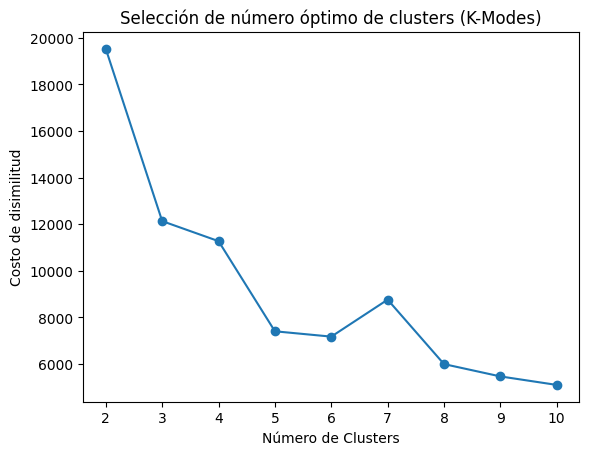

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

costs = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(df3[var])
    print(k)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Costo de disimilitud')
plt.title('Selección de número óptimo de clusters (K-Modes)')
plt.show()

In [ ]:
# Modelado
# ==============================================================================

# Kluster
k_optimo = 4
kmodes_final = KModes(n_clusters=k_optimo, init='Huang', n_init=10, verbose=1, random_state= 42)
df3['cluster'] = kmodes_final.fit_predict(df3[var])

# Análisis de los clusters
cluster_summary = df3.groupby('cluster').agg(lambda x: x.mode().iloc[0])

print("Resumen por cluster:")
print(cluster_summary)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 19182.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 17838.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 18052.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 11323.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 593, cost: 11344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 475, cost: 8261.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 711, cost: 18975.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, itera

In [ ]:
# visualizacion mapa
# ==============================================================================


df_dots = df3[["latitud", "longitud", "cluster"]]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa


Output hidden; open in https://colab.research.google.com to view.

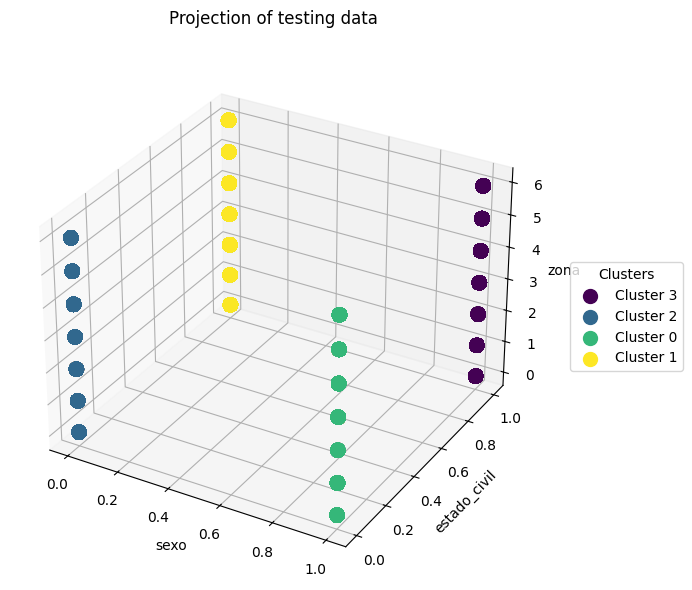

In [ ]:
# visualizacion de variables clusterizadas
# ==============================================================================

fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Obtener los clusters únicos
clusters_unicos = df3['cluster'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(clusters_unicos)))

# Graficar cada cluster por separado con su respectiva etiqueta
for i, cluster in enumerate(clusters_unicos):
    subset = df3[df3['cluster'] == cluster]
    kernel_pca_proj_ax.scatter(
        subset[var[0]],
        subset[var[1]],
        subset[var[2]],
        color=colors[i],
        label=f'Cluster {cluster}',
        s=100
    )

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel(var[0])
kernel_pca_proj_ax.set_ylabel(var[1])
kernel_pca_proj_ax.set_zlabel(var[2])
kernel_pca_proj_ax.set_title("Projection of testing data\n")
kernel_pca_proj_ax.legend(title="Clusters")

kernel_pca_proj_ax.legend(
    title="Clusters",
    loc='center left',
    bbox_to_anchor=(1.05, 0.5)
)

plt.tight_layout()
plt.show()


In [ ]:
# Volver a valores originales para analisis
# ==============================================================================

cluster_summary = df3.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df3.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()


,cluster,sexo,estado_civil,zona,Cantidad
0,0,Mujer,soltero,Centro,11114
1,1,Hombre,soltero,Zona Norte,3704
2,2,Hombre,en_relacion,Centro,6877
3,3,Hombre,soltero,Centro,8305


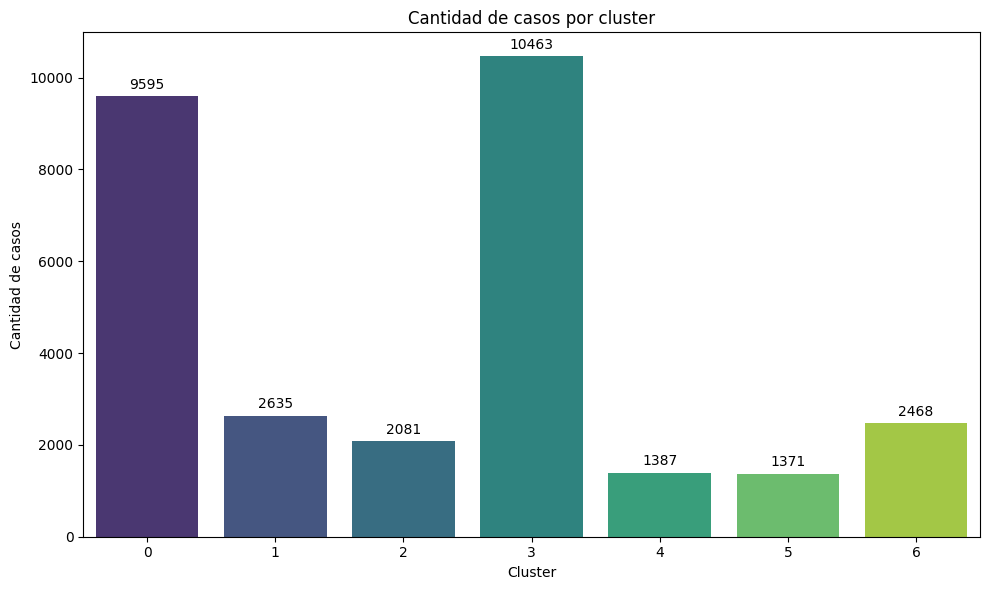

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

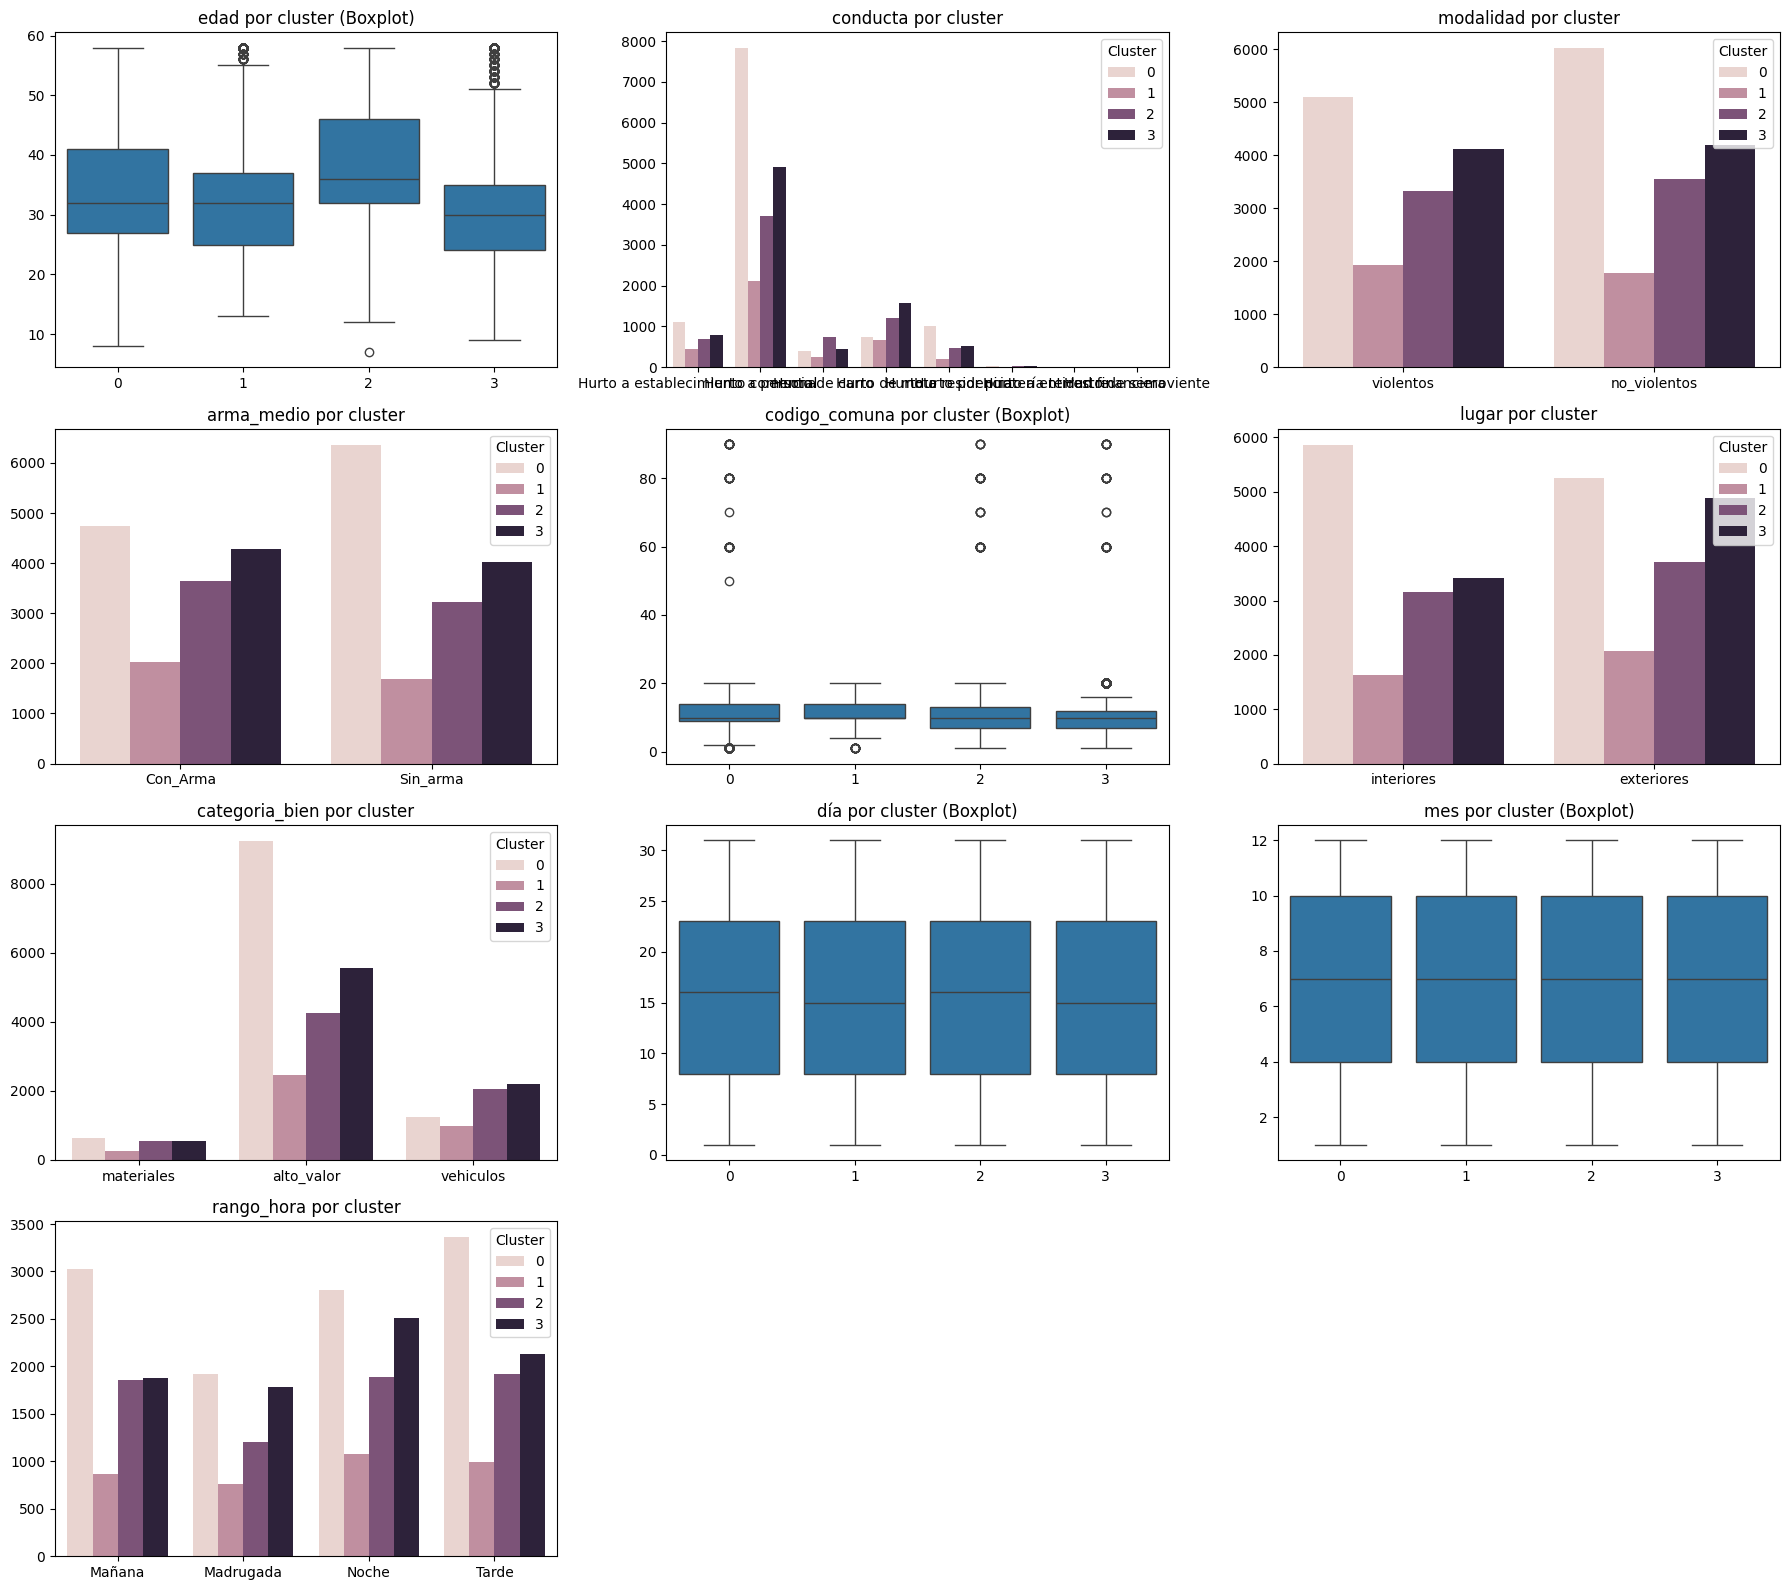

In [ ]:
for col in df3.columns:
    if col in encoder:
        df3[col] = df3[col].round().astype(int)
        df3[col] = encoder[col].inverse_transform(df3[col])


# Variables a analizar (excluimos latitud y longitud)
vars_to_plot = [col for col in df3.columns if col not in var + ['latitud', 'longitud', 'cluster', 'dia']]

# Graficar
n = len(vars_to_plot)
cols = 3
rows = (n // cols) + int(n % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    if df3[var].nunique() <= 10:

        sns.countplot(data=df3, x=var, hue='cluster', ax=ax)
        ax.set_title(f'{var} por cluster')
        ax.legend(title='Cluster')
    else:

        sns.boxplot(data=df3, x='cluster', y=var, ax=ax)
        ax.set_title(f'{var} por cluster (Boxplot)')

    ax.set_xlabel('')
    ax.set_ylabel('')


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()